### Content Analysis Community Pages - Inmigration Posts
### Topic Modeling 

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

#TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer

# spacy for lemmatization
import spacy

#nltk
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
def clean_address(row):
    name =  row.lower().split('/')
    if  row.lower().startswith('https') or  row.lower().startswith('http'):       
        return name[3]
    elif row.lower().startswith('www'):
        return name[1] 
    elif row.lower().startswith('facebook'):
        return name[1]
    else:
        print("Not found", row)
        return None

## 1. Reads  Info
Reads the information from all the posts from the studied period

In [3]:
import os
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [4]:

#path = "Latinx2020/"
posts = pd.read_csv("FB_groups_States_immigration_random.csv")
#We rename the colum Page Name to be able to concat with Group Posts
posts.rename(columns={'Page Name':'Group Name'}, inplace=True)
posts.shape

(7443, 39)

In [5]:
posts['URL']

0       https://www.facebook.com/groups/16676888967880...
1       https://www.facebook.com/groups/28849358188911...
2       https://www.facebook.com/groups/37477537634392...
3       https://www.facebook.com/groups/61424370869838...
4       https://www.facebook.com/groups/123687966213/p...
                              ...                        
7438    https://www.facebook.com/groups/35019948203857...
7439    https://www.facebook.com/groups/35019948203857...
7440    https://www.facebook.com/groups/60036188006474...
7441    https://www.facebook.com/groups/12531645783077...
7442    https://www.facebook.com/groups/16671152341232...
Name: URL, Length: 7443, dtype: object

## 9. Filter the most relevant columns
### Add column to concat Message, Description, Link Text

In [6]:
concat_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('') + (' ' + posts['Link']).fillna('')
posts['MessageDescr'] = concat_message

concat_just_message = posts['Message'].fillna('') + (' ' + posts['Description']).fillna('')+ (' ' + posts['Link Text']).fillna('')
posts['MessageOnly'] = concat_just_message

In [7]:
posts.columns

Index(['Unnamed: 0', 'name', 'Page or Account URL', 'List', 'State', 'state',
       'Facebook Id', 'Group Name', 'User Name', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly'],
      dtype='object')

In [8]:
posts["Created"].head(5)

0    2020-09-28 11:06:42 EDT
1    2020-10-06 12:49:14 EDT
2    2020-10-07 21:08:27 EDT
3    2020-09-20 12:23:54 EDT
4    2020-09-04 20:19:50 EDT
Name: Created, dtype: object

In [9]:
posts['converted_date'] = pd.to_datetime(posts["Created"])
posts['converted_date']

0      2020-09-28 11:06:42-04:00
1      2020-10-06 12:49:14-04:00
2      2020-10-07 21:08:27-04:00
3      2020-09-20 12:23:54-04:00
4      2020-09-04 20:19:50-04:00
                  ...           
7438   2020-10-12 18:22:13-04:00
7439   2020-09-26 09:51:37-04:00
7440   2020-10-09 20:32:54-04:00
7441   2020-09-24 10:30:05-04:00
7442   2020-08-25 13:33:16-04:00
Name: converted_date, Length: 7443, dtype: datetime64[ns, tzlocal()]

In [10]:
posts['converted_date']=posts['converted_date'].dt.date

In [11]:
import seaborn as sns
pd.set_option('display.max_rows', None)
group_date = posts.groupby('converted_date').agg({'Facebook Id':'count'}).reset_index().rename(columns={'Facebook Id':'count'})
group_date


,converted_date,count
0,2020-08-18,86
1,2020-08-19,118
2,2020-08-20,115
3,2020-08-21,72
4,2020-08-22,67
5,2020-08-23,49
6,2020-08-24,86
7,2020-08-25,112
8,2020-08-26,119
9,2020-08-27,88


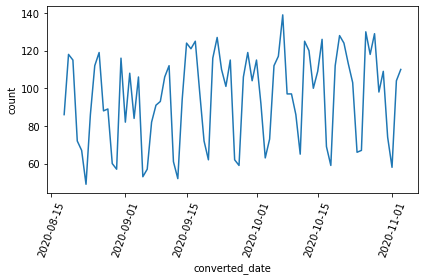

In [12]:
sns.lineplot(data=group_date, x='converted_date', y='count')
plt.xticks(rotation=70)
plt.tight_layout()

In [13]:
posts[posts['Link Text'].str.lower().str.contains("í", na = False)].head(1)

,Unnamed: 0,name,Page or Account URL,List,State,state,Facebook Id,Group Name,User Name,Likes at Posting,...,Image Text,Link Text,Description,Sponsor Id,Sponsor Name,Total Interactions,Overperforming Score,MessageDescr,MessageOnly,converted_date
58,51882,SAN BERNARDINO SWAPMEET LATINO,https://www.facebook.com/groups/446918708790902,Latinos+EstadosGroups,California,California,446918708790902,SAN BERNARDINO SWAPMEET LATINO,NaN,NaN,...,NaN,Ramírez's Furniture,🎊Fall 2020 Hot Deals !!🎊\n8575 Sierra Ave. Spc...,NaN,NaN,0,-12.0,🎊Fall 2020 Hot Deals !!🎊\n8575 Sierra Ave. Sp...,🎊Fall 2020 Hot Deals !!🎊\n8575 Sierra Ave. Sp...,2020-09-27


In [14]:
#!/usr/bin/env python
import re

text = u'This is a smiley face \U0001f602'
print(text) # with emoji

def deEmojify(text):
    
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                          
                           "]+", flags = re.UNICODE)
    
    
    return regrex_pattern.sub(r'',text)

print(deEmojify(text))

def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

This is a smiley face 😂
This is a smiley face 


In [15]:

posts['Group Name']=posts['Group Name'].apply(deEmojify)
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace('"', ''))
posts['Group Name']=posts['Group Name'].apply(lambda i: i.replace(',', ''))
posts['Facebook Id'] = posts['Facebook Id'].astype(int)



### 4. US states

In [16]:
us_states = pd.DataFrame({'State':['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','District of Columbia','Florida',
             'Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts',
             'Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico',
             'New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina',
             'South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']})

##  Count posts in general by state

In [17]:

df_count = posts.groupby(['State']).agg({'Facebook Id':'count'}).reset_index() 

df_count.columns = ['State','Posts_Counts']
df_count.sort_values(by=['State'], ascending=True,inplace=True)
df_count.fillna(0, inplace=True)
df_count['Posts_Counts'] = df_count['Posts_Counts'].astype(int)
df_count.head(10)



,State,Posts_Counts
0,Arizona,55
1,California,383
2,Colorado,9
3,Connecticut,55
4,Florida,2607
5,Georgia,213
6,Illinois,103
7,Iowa,2
8,Kentucky,16
9,Maryland,370


In [18]:
#us_states['State'] = us_states['State']
from functools import reduce
data_frames = [df_count, us_states]
missing_states  = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
missing_states.fillna(0, inplace=True)
missing_states['Posts_Counts'] = missing_states['Posts_Counts'].astype(int)
missing_states

,State,Posts_Counts
0,Arizona,55
1,California,383
2,Colorado,9
3,Connecticut,55
4,Florida,2607
5,Georgia,213
6,Illinois,103
7,Iowa,2
8,Kentucky,16
9,Maryland,370


## 3. Which groups are publishing the majority of the content

In [19]:
group = posts.groupby(['Group Name'])
final_groups = group.agg({'Facebook Id':'count'}).sort_values(by='Facebook Id',ascending=False)
final_groups

,Facebook Id
Group Name,
Venezolanos en Miami,302
LATINOS EN NEW YORK,283
Cubanos en miamifl,135
Peruanos en DC Maryland & Virginia (DMV),135
Venezolanos en La Florida,110
BORICUAS EN KISSIMMEE Y ORLANDO,110
Boricuas en Orlando VIP,104
Venezolanos en Orlando,101
Venezolanos En Orlando,100


In [20]:


republicans = "donald trump|trump|mike pence|nikki haley|john mccain|susan collins|rand paul|chris christie|\
jeff flake|roger stone|george bush|george w. bush|herbert hoover|charles curtis|sarah palin|bill weld|\
rocky de la fuente|joe walsh|mark sanford|herman cain|brad parscale|melania trump|richard nixon|jared kushner|\
ivanka trump|lindsey graham|newt gingrich|rudy giuliani|william barr|mitch mcconnell|gop|republican|\
republicans|republicano|republicanos"


#democrats
democrats = 'joe biden|biden|hillary clinton|kamala harris|michelle obama|bernie sanders|andrew cuomo|tom pérez|\
harry reid|bill clinton|barack obama|adlai stevenson ii|pete buttigieg|michael bennet|deval patrick|andrew yang|\
amy klobuchar|tom steyer|michael bloomberg|elizabeth warren|tulsi gabbard|geraldine ferraro|tony evers|\
nancy pelosi|josh shapiro|democrat|democrats|democratas|democrata'


general_politics = "kanye west|jo jorgensen|spike cohen|howie hawkins|angela walker|don blankenship|gloria la riva|\
brian t. carroll|brock pierce|phil collins|bill hammons|jerome segal|blake huber|mark charles|dario hunter|\
joseph kishore|alyson kennedy|jade simmons|joe mchugh|kyle kopitke|amy coney barrett|ruth bader ginsburg|\
george floyd|oprah winfrey|breonna taylor|geng shuang|philip goldberg|jho low|chris krebs|chris wallace|\
christopher a. wray|louis dejoy|merrick garland|steve scully|susan page|kristen welker|urszula gacek|\
michael georg link|william h. frey|ann selzer|samuel alito|tucker carlson|cynthia stephens|sidney powell|\
shelby pierson|joseph maguire"



posts_democrats = posts.copy()
posts_democrats = posts[posts['MessageDescr'].str.lower().str.contains(democrats   ,na = False)]
print('democrats', posts_democrats.shape)

posts_republicans = posts.copy()
posts_republicans = posts[posts['MessageDescr'].str.lower().str.contains(republicans   ,na = False)]
print('republicans', posts_republicans.shape)

posts_general_politics = posts.copy()
posts_general_politics = posts[posts['MessageDescr'].str.lower().str.contains(general_politics   ,na = False)]
print('general politics', posts_general_politics.shape)


posts_none = posts.copy()
posts_none = posts[~posts['MessageDescr'].str.lower().str.contains(general_politics + '|' + democrats + '|' +republicans ,na = False)]
print('none',posts_none['MessageDescr'].shape)

posts['Link Text'].isna().sum()

democrats (217, 40)
republicans (364, 40)
general politics (35, 40)
none (6988,)


1428

### 6.Filter Posts per each political party
How much each candidate talked about all the topics that Latinx cared about

In [21]:
posts_democrats['MessageDescr'][3:6]

57     BIDENS accomplishments WITH LINKS & Trump’s fa...
80      EN VIVO  El Debate entre los candidatos a la ...
108    ***Join us! Latino Weekend of Action Kickoff!E...
Name: MessageDescr, dtype: object

In [22]:
posts_democrats.columns

Index(['Unnamed: 0', 'name', 'Page or Account URL', 'List', 'State', 'state',
       'Facebook Id', 'Group Name', 'User Name', 'Likes at Posting', 'Created',
       'Type', 'Likes', 'Comments', 'Shares', 'Love', 'Wow', 'Haha', 'Sad',
       'Angry', 'Care', 'Video Share Status', 'Post Views', 'Total Views',
       'Total Views For All Crossposts', 'Video Length', 'URL', 'Message',
       'Link', 'Final Link', 'Image Text', 'Link Text', 'Description',
       'Sponsor Id', 'Sponsor Name', 'Total Interactions',
       'Overperforming Score', 'MessageDescr', 'MessageOnly',
       'converted_date'],
      dtype='object')

In [23]:
df_dem = posts_democrats['State'].value_counts().reset_index()
df_dem.columns = ['State','Count']

In [24]:
df_rep = posts_republicans['State'].value_counts().reset_index()
df_rep.columns = ['State','Count']

In [25]:
df_gen_pol = posts_general_politics['State'].value_counts().reset_index()
df_gen_pol.columns = ['State','Count']

In [26]:
df_gen_info = posts_none['State'].value_counts().reset_index()
df_gen_info.columns = ['State','Count']

In [27]:
from functools import reduce
data_frames = [df_dem, df_rep,df_gen_pol,df_gen_info]
df_all = reduce(lambda  left,right: pd.merge(left,right,on=['State'],
                                            how='outer'), data_frames)
df_all.columns = ['State','Posts_Dem','Posts_Rep', 'Posts_Gen_Pol','Post_Gen_Info']
df_all.sort_values(by=['State'], ascending=True,inplace=True)
df_all.fillna(0, inplace=True)
df_all['Posts_Dem'] = df_all['Posts_Dem'].astype(int)
df_all['Posts_Rep'] = df_all['Posts_Rep'].astype(int)
df_all['Posts_Gen_Pol'] = df_all['Posts_Gen_Pol'].astype(int)
df_all['Post_Gen_Info'] = df_all['Post_Gen_Info'].astype(int)
df_all

,State,Posts_Dem,Posts_Rep,Posts_Gen_Pol,Post_Gen_Info
24,Arizona,0,0,0,55
2,California,20,45,5,327
28,Colorado,0,0,0,9
21,Connecticut,0,1,0,54
0,Florida,63,118,5,2466
15,Georgia,1,6,0,207
12,Illinois,1,3,0,100
30,Iowa,0,0,0,2
9,Kentucky,4,8,0,6
3,Maryland,17,37,6,329


In [28]:
dummy = posts_democrats[posts_democrats['MessageDescr'].str.contains("gop")]
pd.set_option('display.max_colwidth', 400)
dummy['MessageDescr']

1461    Latinos L ❤ V E P R S I D E N T. D O N A L D J T R U M P ! 🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸🇺🇸 #LATINOSFORTRUMP2020 #TrumpTrain #walkaway #VoteRed2020 #RedWave2020 #fliprgvred #MAGA #Trump2020 #bestpresident #LatinosForTrump #LEXIT #TrumpTrain #VoteRed #DonaldTrump #RepublicanParty #WalkAwayFromDemocrats #creepyjoe2020 #republicangop #KeepTexasRed https://www.facebook.com/344807286197610/posts/59410633...
Name: MessageDescr, dtype: object

## FB Groups Political Posts

In [29]:
posts_political =  pd.concat([posts_democrats,posts_republicans,posts_general_politics])

#posts_political = df_posts_state[df_posts_state['MessageDescr'].str.lower().str.contains(democrats + '|' +republicans+ '|' +general_politics, na = False)]
df_political = posts_political['State'].value_counts().reset_index()
df_political.columns = ['State','Count']
df_political

,State,Count
0,Florida,186
1,New York,71
2,California,70
3,Maryland,60
4,New Jersey,34
5,Texas,33
6,Washington,15
7,Pennsylvania,12
8,Kentucky,12
9,Ohio,10


## Tokenize words and Clean-up text

In [31]:
content = posts.copy()
content['MessageDescr'].head()

0     La política es apasionante y polémica. Muchos de nosotros nos dejamos seducir por los medios y las campañas de marketing que nos venden a candidatos como si fueran hamburguesas.\nPor eso nosotros como votantes responsables debemos estudiar y analizar las propuestas.\n\n"Loreando Entre Causas" también quiere ayudarte no solo a entretenerte y quitarte el stress acumulado durante la semana, si n...
1    Te gustaria Vivir en una Comunidad de Viviendas Unifamiliares Son 42 Viviendas ,ubicadas en  147 th Avenue SW 22nd Street\nMiami, Fl 33175\n\nEs una comunidad contemporánea de viviendas unifamiliares de nueva construcción que ofrece diversos diseños arquitectónicos de casas de uno y dos pisos que van desde planos de planta de 4 a 5 habitaciones y 3 ½ a 5 ½ baños que van desde 2200-4300 pies cu...
2    Necesitas abrir una corporación en EEUU? No tienes idea cómo comenzar? Oyes mucho sobre corporaciones LLC pero la verdad es que no tienes ni idea si es la que mas te conviene? Si has 

In [32]:
content['cleanMessage'] = content['MessageDescr'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
content['cleanMessage'].shape

(7443,)

In [33]:
# Convert to list
data = content.cleanMessage.tolist()

In [34]:
# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]


In [35]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:2])

[['la', 'politica', 'es', 'apasionante', 'polemica', 'muchos', 'de', 'nosotros', 'nos', 'dejamos', 'seducir', 'por', 'los', 'medios', 'las', 'campanas', 'de', 'marketing', 'que', 'nos', 'venden', 'candidatos', 'como', 'si', 'fueran', 'hamburguesas', 'por', 'eso', 'nosotros', 'como', 'votantes', 'responsables', 'debemos', 'estudiar', 'analizar', 'las', 'propuestas', 'loreando', 'entre', 'causas', 'tambien', 'quiere', 'ayudarte', 'no', 'solo', 'entretenerte', 'quitarte', 'el', 'stress', 'acumulado', 'durante', 'la', 'semana', 'si', 'no', 'que', 'ademas', 'contribuir', 'que', 'te', 'formes', 'tu', 'propia', 'idea', 'de', 'por', 'quien', 'votar', 'por', 'eso', 'hemos', 'invitados', 'dos', 'grander', 'analistas', 'politicos', 'de', 'ambas', 'carpas', 'politicas', 'para', 'que', 'nos', 'expliquen', 'por', 'que', 'votar', 'por', 'el', 'candidato', 'al', 'cual', 'representan', 'en', 'un', 'debate', 'que', 'va', 'estar', 'encendido', 'prepara', 'tus', 'preguntas', 'este', 'jueves', 'ro', 'octub

#### Creating Bigram and Trigram Models

In [36]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['la', 'politica', 'es', 'apasionante', 'polemica', 'muchos', 'de', 'nosotros', 'nos', 'dejamos', 'seducir', 'por', 'los', 'medios', 'las', 'campanas', 'de', 'marketing', 'que', 'nos', 'venden', 'candidatos', 'como', 'si', 'fueran', 'hamburguesas', 'por', 'eso', 'nosotros', 'como', 'votantes', 'responsables', 'debemos', 'estudiar', 'analizar', 'las', 'propuestas', 'loreando', 'entre', 'causas', 'tambien', 'quiere', 'ayudarte', 'no', 'solo', 'entretenerte', 'quitarte', 'el', 'stress', 'acumulado', 'durante', 'la', 'semana', 'si', 'no', 'que', 'ademas', 'contribuir', 'que', 'te', 'formes', 'tu', 'propia', 'idea', 'de', 'por', 'quien', 'votar', 'por', 'eso', 'hemos', 'invitados', 'dos', 'grander', 'analistas', 'politicos', 'de', 'ambas', 'carpas', 'politicas', 'para', 'que', 'nos', 'expliquen', 'por', 'que', 'votar', 'por', 'el', 'candidato', 'al', 'cual', 'representan', 'en', 'un', 'debate', 'que', 'va', 'estar', 'encendido', 'prepara', 'tus', 'preguntas', 'este', 'jueves', 'ro', 'octubr

## Remove Stopwords, Make Bigrams and Lemmatize

In [37]:
#import nltk
#nltk.download('stopwords')
stop_words = stopwords.words('spanish')
stop_words.extend(stopwords.words('english'))
stop_words.extend(['su','sus','al','de','en','el','tal','con','mas','si','dos','pm','ser','ex','could','like','would','get','many','much','\ufeff1'])

In [38]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#https://stackoverflow.com/questions/54334304/spacy-cant-find-model-en-core-web-sm-on-windows-10-and-python-3-5-3-anacon
#!python3 -m spacy download es_core_news_sm
#!python -m spacy download es
nlp = spacy.load('es', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [40]:
print(data_words_nostops[1:2])

[['gustaria', 'vivir', 'comunidad', 'viviendas', 'unifamiliares', 'viviendas', 'ubicadas', 'th', 'avenue', 'sw', 'nd', 'street', 'miami', 'fl', 'comunidad', 'contemporanea', 'viviendas', 'unifamiliares', 'nueva', 'construccion', 'ofrece', 'diversos', 'disenos', 'arquitectonicos', 'casas', 'pisos', 'van', 'planos', 'planta', 'habitaciones', 'banos', 'van', 'pies', 'cuadrados', 'mayor', 'informacion', 'nuevas', 'construcciones', 'contactame', 'programa', 'visita', 'lisayly', 'hurtado', 'cambiando', 'estilo', 'vida', 'miamiflorida', 'inmuebleventas', 'teamleader', 'construcciones', 'bienesraices', 'negocios', 'inversion', 'real', 'lisy', 'realtor']]


## Bag of Words

In [41]:
def combine_words(word1,word2,dictionary):

    if word1 in dictionary and word2 in dictionary:
        concat_name = word1+" / "+word2
        dictionary[concat_name] = dictionary[word1] + dictionary[word2]
        dictionary.pop(word1, None)
        dictionary.pop(word2, None)
        result = dictionary.pop(word1, None)
        result = dictionary.pop(word2, None)
    return dictionary

In [42]:
flat_list_words = [item for sublist in data_lemmatized for item in sublist]
count_words = Counter(flat_list_words)

In [43]:
final_dict = combine_words('donald','trump',count_words)
final_dict = combine_words('joe','biden',count_words)
final_dict = combine_words('kamala','harris',count_words)
final_dict = combine_words('american','america',count_words)
final_dict = combine_words('estados','unidos',count_words)
final_dict = combine_words('voters','vote',count_words)
final_dict = combine_words('mexico','mexican',count_words)
final_dict = combine_words('casa','blanca',count_words)
final_dict = combine_words('venezuela','venezuelans',count_words)
final_dict = combine_words('latino','latinos',count_words)
final_dict = combine_words('american / america','americans',count_words)
final_dict = combine_words('voters / vote','voting',count_words)
final_dict = combine_words('puerto','rico',count_words)
final_dict = combine_words('communism','communist',count_words)
final_dict = combine_words('ee','uu',count_words)
final_dict = combine_words('united','states',count_words)
final_dict = combine_words('president','presidente',count_words)
final_dict = combine_words('democrat','democrats',count_words)
final_dict = combine_words('informacion','informar',count_words)
final_dict = combine_words('covid','coronavirus',count_words)
final_dict = combine_words('democrat / democrats','democratas',count_words)

In [44]:
final_dict.most_common(1000)

[('hacer', 979),
 ('solo', 916),
 ('decir', 883),
 ('hoy', 830),
 ('trabajar', 820),
 ('casar', 772),
 ('licenciar', 725),
 ('personar', 639),
 ('ano', 625),
 ('querer', 584),
 ('poder', 574),
 ('nuevo', 539),
 ('seguro', 530),
 ('mejor', 503),
 ('photos', 503),
 ('servicio', 500),
 ('llamar', 478),
 ('ayudar', 473),
 ('tambien', 456),
 ('comprar', 429),
 ('auto', 427),
 ('necesitar', 420),
 ('pagar', 415),
 ('tiempo', 399),
 ('contar', 396),
 ('salir', 391),
 ('vida', 385),
 ('esperar', 383),
 ('saber', 365),
 ('dar', 358),
 ('partir', 350),
 ('donald / trump', 348),
 ('bueno', 338),
 ('vivir', 337),
 ('cliente', 336),
 ('tener', 332),
 ('ahora', 327),
 ('post', 323),
 ('buscar', 314),
 ('usar', 312),
 ('social', 306),
 ('preguntar', 303),
 ('familia', 300),
 ('abogar', 286),
 ('cambiar', 275),
 ('ver', 273),
 ('ir', 270),
 ('pedir', 269),
 ('oportunidad', 268),
 ('hablar', 263),
 ('siempre', 259),
 ('llegar', 258),
 ('legal', 257),
 ('importar', 255),
 ('pasar', 250),
 ('hora', 248),

In [45]:
docs = ([' '.join(ele) for ele in data_lemmatized] )


In [47]:
cv=CountVectorizer() 
word_count_vector=cv.fit_transform(docs)
#word_count_vector.toarray()

# Convert bow_matrix into a DataFrame
bow_df = pd.DataFrame(word_count_vector.toarray())

# Map the column names to vocabulary 
bow_df.columns = cv.get_feature_names()

# Print bow_df
#print(bow_df)

In [48]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [49]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
hacer,3.356966
solo,3.369814
hoy,3.429003
licenciar,3.475813
trabajar,3.536737
casar,3.545263
decir,3.566025
photos,3.698558
ano,3.790480
querer,3.805916


In [50]:
# count matrix 
count_vector=cv.transform(docs) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [51]:
feature_names = cv.get_feature_names() 
 
#get tfidf vector for first document 
first_document_vector=tf_idf_vector[0] 
 
#print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df = df[(df != 0).all(1)]
df.sort_values(by=["tfidf"],ascending=False).to_csv("outlets_tfidf.csv")

In [52]:
df

,tfidf
acumular,0.164962
ademar,0.117420
analista,0.182264
analizar,0.155409
apasionante,0.202372
ayudarte,0.123132
candidato,0.260913
carpir,0.187161
causar,0.126664
contribuir,0.167053


In [95]:
word = df.index[1]
content["lowercase"] = content['cleanMessage'].apply(lambda x: x.lower())
word_messages = content[content['lowercase'].str.contains(word)]
word_messages = word_messages['lowercase'].value_counts(ascending=False).rename_axis('unique_messages').reset_index(name='counts')
word_messages.to_csv(word + "_messages.csv")
word_messages

,unique_messages,counts


### Repeated messages

In [56]:
content['Total Interactions']=content['Total Interactions'].astype(str).str.replace(',', '').astype(int)
results = content.groupby(['MessageDescr','Link']).aggregate({'MessageDescr': 'count','Likes': 'sum','Comments': 'sum', 'Shares': 'sum', 'Love': 'sum', 'Wow': 'sum', 'Haha': 'sum', 'Sad': 'sum',
       'Angry': 'sum', 'Care': 'sum','Total Interactions':'sum'})
results.rename(columns={"MessageDescr": "Counts"}, inplace=True)
results.shape
#results.to_csv("mostpopularNewsMedia.csv")

(6286, 11)

In [58]:
results.sort_values(by='Total Interactions',ascending=False).head(20)

,,Counts,Likes,Comments,Shares,Love,Wow,Haha,Sad,Angry,Care,Total Interactions
MessageDescr,Link,,,,,,,,,,,
"Wow, I don't remember anyone caring. The actor told fans he's a ""political independent and centrist"" who has voted for both Democrats and Republicans in the past. Dwayne Johnson backs Joe Biden and Kamala Harris in first ever presidential endorsement: 'Best choice to lead our country' https://www.yahoo.com/entertainment/dwayne-johnson-endorses-joe-biden-kamala-harris-132003067.html",https://www.yahoo.com/entertainment/dwayne-johnson-endorses-joe-biden-kamala-harris-132003067.html,1,14,43,270,0,0,52,7,15,0,401
"Good day! Buen día! 🍂🍄🌰🐿 Some pics from my daily walk. I found this abandoned hidden Thunderbird in a farm house, I am guessing is from the late 70s ? Had lovely company from a little guy that was also observing Gods creation.🍁🐿 #stayfsafe Be nice 🍃🧡 Photos from Celia Edenholm's post https://www.facebook.com/photo.php?fbid=3757989710988378&set=gm.2733168590228394&type=3",https://www.facebook.com/photo.php?fbid=3757989710988378&set=gm.2733168590228394&type=3,1,142,72,0,21,1,0,0,0,4,240
"Serpico - 1973 Who likes this movie? Frank Serpico (Al Pacino) is an idealistic New York City cop who refuses to take bribes, unlike the rest of the force. His actions get Frank shunned by the other officers, and often placed in dangerous situations by his partners. When his superiors ignore Frank's accusations of corruption, he decides to go public with the allegations. Although this causes the Knapp Commission to investigate his claims, Frank has also placed a target on himself. The film is based on a true story. Photos from Natacha Llagostera's post https://www.facebook.com/photo.php?fbid=1324393437892465&set=gm.2693442987534288&type=3",https://www.facebook.com/photo.php?fbid=1324393437892465&set=gm.2693442987534288&type=3,1,130,54,6,18,0,0,0,0,0,208
"Kyle Rittenhouse, age 17, killed 2 people & wounded another last night at a BLM protest in Kenosha, Wisconsin. He belonged to an armed right-wing militia, & video showed police thank him & give him water prior to the killings. As he and other right-wingers fired into the crowd of peaceful protesters, again police did nothing according to several eye witnesses. Look at this boy's age. Look at his eyes. If you think America's white supremacy and terror is going away if Trump loses in November, this is the sad reality. Kyle Rittenhouse, age 17, killed 2 people & wounded another last night at a BLM protest in Kenosha, Wisconsin. He belonged to an armed right-wing militia, & video showed police thank him & give him water prior to the killings. As he and other right-wingers fired into the crowd of peaceful protesters, again police did nothing according to several eye witnesses. Look at this boy's age. Look at his eyes. If you think America's white supremacy and terror is going away if Trump loses in November, this is the sad reality. The Other 98% https://www.facebook.com/TheOther98/photos/a.115969958413991/5073476812663256/?type=3",https://www.facebook.com/TheOther98/photos/a.115969958413991/5073476812663256/?type=3,1,5,165,6,0,3,0,10,17,0,206
"""Fuimos nosotros quienes sacamos el pecho y reconstruimos"", dice Marc Anthony al señalar el abandono del gobierno federal. Marc Anthony pide ""no olvidar"" desastre de María en elecciones de EEUU https://bit.ly/3hPdfPQ",https://bit.ly/3hPdfPQ,2,34,137,4,4,0,2,0,5,1,187
Muy Buenas Noches llena de Bendiciones..Felices Sueños.. Photos from Domingo Rodriguez's post https://www.facebook.com/photo.php?fbid=1422440927953079&set=gm.2693601034185150&type=3,https://www.facebook.com/photo.php?fbid=1422440927953079&set=gm.2693601034185150&type=3,1,71,98,2,15,0,0,0,0,1,187
Muy Buenas Noches llena de Bendiciones...Felices Sueños.. Photos from Domingo Rodriguez's post https://www.facebook.com/photo.php?fbid=1475454432651728&set=gm.2747685098776743&type=3,https://www.facebook.com/photo.php?fbid=1475454432651728&set=gm.2747685098776743&type=3,1,56,96,10,19,0,0

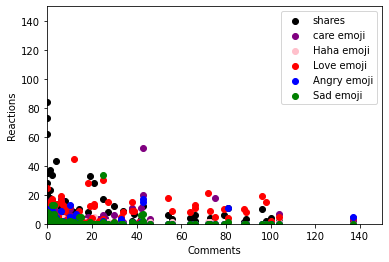

In [59]:
results.reset_index()
plt.xlim(0,150)
plt.ylim(0,150)

plt.xlabel('Comments')
plt.ylabel('Reactions')
plt.scatter(results.Comments, results.Shares,c='black',label='shares')
plt.scatter(results.Comments, results.Haha,c='purple',label='care emoji')
plt.scatter(results.Comments, results.Wow,c='pink',label='Haha emoji')
plt.scatter(results.Comments, results.Love,c='red',label='Love emoji')
plt.scatter(results.Comments, results.Angry,c='blue',label='Angry emoji')
plt.scatter(results.Comments, results.Sad,c='green',label='Sad emoji')

plt.legend()


## Topic Modeling
### Create the Dictionary and Corpus needed for Topic Modeling

In [60]:


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2)]]


[[('acumular', 1),
  ('ademar', 1),
  ('analista', 1),
  ('analizar', 1),
  ('apasionante', 1),
  ('ayudarte', 1),
  ('candidato', 2),
  ('carpir', 1),
  ('causar', 1),
  ('contribuir', 1),
  ('debatir', 1),
  ('dejar', 1),
  ('encender', 1),
  ('entretenerte', 1),
  ('estudiar', 1),
  ('explicar', 1),
  ('formar', 1),
  ('grander', 1),
  ('hamburguesa', 1),
  ('ideo', 1),
  ('invitar', 1),
  ('ir', 1),
  ('jueves', 1),
  ('loreando', 1),
  ('medio', 1),
  ('octubre', 1),
  ('polemica', 1),
  ('politica', 1),
  ('politicas', 1),
  ('politicos', 1),
  ('preguntar', 1),
  ('preparar', 1),
  ('propuesta', 1),
  ('querer', 1),
  ('quitarte', 1),
  ('responsable', 1),
  ('seducir', 1),
  ('semana', 1),
  ('solo', 1),
  ('tambien', 1),
  ('votante', 1),
  ('votar', 2)]]

## Buiding the Topic Model

In [62]:

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

## View the topics in LDA model

In [63]:
# Print the Keyword in the 10 topics
#The weights reflect how important a keyword is to that topic.
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.059*"feliz" + 0.057*"orlar" + 0.051*"calidad" + 0.046*"aguar" + '
  '0.044*"hogar" + 0.042*"condado" + 0.035*"acceso" + 0.034*"areas" + '
  '0.031*"mercar" + 0.028*"price"'),
 (1,
  '0.121*"saber" + 0.088*"cambiar" + 0.056*"salud" + 0.045*"viernes" + '
  '0.045*"coser" + 0.044*"resultar" + 0.032*"foto" + 0.030*"amor" + '
  '0.028*"agradecer" + 0.028*"manana"'),
 (2,
  '0.309*"decir" + 0.111*"abogar" + 0.062*"alto" + 0.053*"ley" + 0.042*"dudar" '
  '+ 0.029*"claro" + 0.026*"punto" + 0.017*"podria" + 0.015*"consejo" + '
  '0.010*"salvar"'),
 (3,
  '0.089*"oportunidad" + 0.063*"seguir" + 0.048*"permiso" + 0.047*"personal" + '
  '0.046*"semana" + 0.046*"bien" + 0.036*"anunciar" + 0.032*"solicitar" + '
  '0.028*"cerrar" + 0.027*"fin"'),
 (4,
  '0.133*"ayudar" + 0.124*"auto" + 0.075*"comprar" + 0.073*"preguntar" + '
  '0.064*"recordar" + 0.040*"ingreso" + 0.032*"primero" + 0.030*"venir" + '
  '0.029*"cercar" + 0.029*"invitar"'),
 (5,
  '0.079*"trabajar" + 0.063*"licenciar" + 0.062*

## Compute Model Perplexity and Coherence Score

In [64]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -19.25479762302978

Coherence Score:  0.40167910367990983


## Visualize the topics-keywords

In [65]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.297563 -0.285965       1        1  16.835817
11     0.288216 -0.038845       2        1  16.604923
5      0.266987  0.352205       3        1  15.237827
15     0.034497  0.002626       4        1   6.279505
4      0.007789  0.000807       5        1   4.579186
12    -0.019477 -0.000698       6        1   4.214225
19    -0.016326 -0.000549       7        1   3.905350
18    -0.038876 -0.001534       8        1   3.565896
3     -0.040469 -0.001583       9        1   3.548829
1     -0.030787 -0.001206      10        1   3.451119
7     -0.041841 -0.001642      11        1   3.388806
2     -0.060831 -0.002228      12        1   2.935981
14    -0.066437 -0.002428      13        1   2.657934
6     -0.062968 -0.002301      14        1   2.550379
0     -0.057787 -0.002185      15        1   2.497284
17    -0.080032 -0.002722      16        1   2.128291
16    -0.091053 -0.002911      17        1   1.682227
10    -0.080803 -0.002723      18        1   1.644350
9     -0.100413 -0.003033      19        1   1.243857
13    -0.106953 -0.003083      20        1   1.048220, topic_info=                                  Term         Freq        Total Category  \
146                              decir  1388.000000  1388.000000  Default   
710                              hacer  2273.000000  2273.000000  Default   
484                           trabajar  1838.000000  1838.000000  Default   
200                                hoy  1826.000000  1826.000000  Default   
38                                solo  1749.000000  1749.000000  Default   
60                               nuevo  1089.000000  1089.000000  Default   
693                             ayudar   930.000000   930.000000  Default   
46                               casar  1547.000000  1547.000000  Default   
94                           licenciar  1469.000000  1469.000000  Default   
598                               auto   872.000000   872.000000  Default   
727                             photos   650.000000   650.000000  Default   
453                           personar  1442.000000  1442.000000  Default   
230                                ano  1357.000000  1357.000000  Default   
165                              poder  1292.000000  1292.000000  Default   
71                               vivir   619.000000   619.000000  Default   
103                              saber   642.000000   642.000000  Default   
160                              mejor  1233.000000  1233.000000  Default   
1071                              vida   625.000000   625.000000  Default   
375                           servicio  1165.000000  1165.000000  Default   
33                              querer  1107.000000  1107.000000  Default   
427                             llamar  1024.000000  1024.000000  Default   
482                              tener   503.000000   503.000000  Default   
1008                            abogar   498.000000   498.000000  Default   
1060                           mejorar   510.000000   510.000000  Default   
135                             contar   975.000000   975.000000  Default   
431                             tiempo   919.000000   919.000000  Default   
118                          vehicular   431.000000   431.000000  Default   
39                             tambien   950.000000   950.000000  Default   
407                              trump   426.000000   426.000000  Default   
1188                             pasar   514.000000   514.000000  Default   
710                              hacer  2272.230225  2273.707031   Topic1   
200                                hoy  1825.104370  1826.576660   Topic1   
38                                solo  1747.719971  1749.192261   Topic1   
160                              mejor  1231.661255  1233.133545   Topic1   
375                           servicio  1164.250366  1165.722656   Topic1 

## Building LDA Mallet Model

In [66]:
os.getcwd()

'/home/claudia/Documents/Latinx2020'

In [67]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
from gensim.models.wrappers import LdaMallet


In [68]:
mallet_path = '/home/claudia/Documents/Latinx2020/mallet-2.0.8/bin/mallet' # update this path

In [69]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [70]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('tiempo', 0.027260981912144704),
   ('compartir', 0.02648578811369509),
   ('poder', 0.020025839793281652),
   ('vivir', 0.016925064599483203),
   ('amigo', 0.01627906976744186),
   ('gran', 0.01614987080103359),
   ('invitar', 0.015633074935400518),
   ('pedir', 0.014857881136950904),
   ('partir', 0.013695090439276485),
   ('apoyar', 0.013049095607235143)]),
 (10,
  [('citar', 0.017414802582194865),
   ('hoy', 0.01621378171445729),
   ('cuidar', 0.016063654105990092),
   ('resultar', 0.013961867587449332),
   ('piel', 0.01306110193664615),
   ('viejo', 0.012910974328178951),
   ('llamanos', 0.012310463894310163),
   ('recordar', 0.01095931541810539),
   ('ayudar', 0.010659060201170995),
   ('especial', 0.010508932592703798)]),
 (4,
  [('servicio', 0.05680891546615928),
   ('hacer', 0.01984234846425659),
   ('partir', 0.01630877955966295),
   ('mejor', 0.016036966567001903),
   ('tambien', 0.014406088611035607),
   ('contar', 0.014270182114705083),
   ('envios', 0.01331883664

## Finding the optimal number of topics for LDA

In [71]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [84]:
# Can take a long time to run.

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=22, step=2)

10


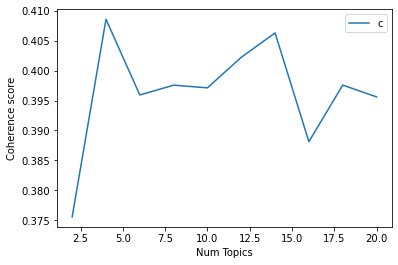

In [85]:
# Show graph
limit=22; start=2; step=2;
x = range(start, limit, step)
print(len(coherence_values))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [86]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3756
Num Topics = 4  has Coherence Value of 0.4086
Num Topics = 6  has Coherence Value of 0.3959
Num Topics = 8  has Coherence Value of 0.3976
Num Topics = 10  has Coherence Value of 0.3971
Num Topics = 12  has Coherence Value of 0.4022
Num Topics = 14  has Coherence Value of 0.4063
Num Topics = 16  has Coherence Value of 0.3881
Num Topics = 18  has Coherence Value of 0.3976
Num Topics = 20  has Coherence Value of 0.3956


In [90]:
# Select the model and print the topics
optimal_model = model_list[6]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.025*"trump" + 0.021*"decir" + 0.013*"ano" + 0.013*"presidente" + '
  '0.013*"votar" + 0.012*"venezolano" + 0.009*"coronavirus" + 0.008*"elección" '
  '+ 0.007*"despues" + 0.006*"millón"'),
 (1,
  '0.053*"trabajar" + 0.052*"licenciar" + 0.032*"seguro" + 0.021*"tener" + '
  '0.021*"pagar" + 0.019*"ayudar" + 0.019*"agente" + 0.018*"ofrecer" + '
  '0.017*"casar" + 0.016*"obtener"'),
 (2,
  '0.045*"photos" + 0.041*"auto" + 0.032*"post" + 0.027*"social" + '
  '0.023*"vehicular" + 0.020*"contar" + 0.019*"carro" + 0.019*"importar" + '
  '0.018*"seguro" + 0.018*"licenciar"'),
 (3,
  '0.020*"octubre" + 0.018*"hora" + 0.018*"usar" + 0.018*"clase" + '
  '0.015*"poder" + 0.014*"recibir" + 0.013*"iniciar" + 0.013*"llamar" + '
  '0.013*"visitar" + 0.013*"espanol"'),
 (4,
  '0.024*"bueno" + 0.024*"mejor" + 0.023*"querer" + 0.020*"tiempo" + '
  '0.019*"hacer" + 0.018*"trabajar" + 0.014*"cambiar" + 0.014*"negociar" + '
  '0.014*"poder" + 0.013*"buscar"'),
 (5,
  '0.026*"pedir" + 0.025*"compart

## Finding the dominant topic in each sentence

In [91]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.1857,"trump, decir, ano, presidente, votar, venezolano, coronavirus, elección, despues, millón","La política es apasionante y polémica. Muchos de nosotros nos dejamos seducir por los medios y las campañas de marketing que nos venden a candidatos como si fueran hamburguesas. Por eso nosotros como votantes responsables debemos estudiar y analizar las propuestas. ""Loreando Entre Causas"" también quiere ayudarte no solo a entretenerte y quitarte el stress acumulado durante la semana, si no qu..."
1,1,12.0,0.3243,"casar, vender, mayor, cuidar, ubicar, piel, alto, riesgo, aguar, aumentar","Te gustaria Vivir en una Comunidad de Viviendas Unifamiliares Son 42 Viviendas ,ubicadas en 147 th Avenue SW 22nd Street Miami, Fl 33175 Es una comunidad contemporánea de viviendas unifamiliares de nueva construcción que ofrece diversos diseños arquitectónicos de casas de uno y dos pisos que van desde planos de planta de 4 a 5 habitaciones y 3 ½ a 5 ½ baños que van desde 2200-4300 pies cuadrad..."
2,2,3.0,0.1479,"octubre, hora, usar, clase, poder, recibir, iniciar, llamar, visitar, espanol","Necesitas abrir una corporación en EEUU? No tienes idea cómo comenzar? Oyes mucho sobre corporaciones LLC pero la verdad es que no tienes ni idea si es la que mas te conviene? Si has respondido ‘si’ a una de las preguntas esto es para ti! Acompáñanos este 16 de octubre en un seminario que estaremos impartiendo para ayudarte con todo lo que necesitas saber. El curso será a través de zoom,..."
3,3,3.0,0.0899,"octubre, hora, usar, clase, poder, recibir, iniciar, llamar, visitar, espanol","Preparate para este fin de semana largo, conociendo las nuevas medidas restricción vehicular. 🚘 y las excepciones aplicadas a turismo durante el mes de agosto. Más información:"
4,4,1.0,0.0858,"trabajar, licenciar, seguro, tener, pagar, ayudar, agente, ofrecer, casar, obtener",Algún electricista licenciado en Florida? Necesito una instalación en Boca Raton.
5,5,7.0,0.0937,"abogar, legal, inmigrante, procesar, unir, ley, familiar, tramitar, solicitar, conocer",CUENTES CON NOSOTROS - SIEMPRE‼️‼️👩‍👩‍👧‍👦👩‍👩‍👧‍👦 Sabemos que este proceso es algo delicado e importante para usted así que déjalo en nuestras manos.😀😀😀 FORMULARIO COMPLETO PARA SER ENTREGADO DE FORMA RÁPIDA👍👍👍 Si necesita sus EXÁMENES MÉDICOS DE INMIGRACIÓN este es el lugar indicado👪👪👪👪
6,6,7.0,0.1780,"abogar, legal, inmigrante, procesar, unir, ley, familiar, tramitar, solicitar, conocer","Tramitamos tu licencia de conducir mexicana sin anticipos, sin salir de casa y pocos requisitos, contamos con un sistema de verificación en portal oficial de gobierno. Para mayor seguridad de nuestros clientes, pregunta sin compromiso Photos from Jesus Perezs post"
7,7,5.0,0.1032,"pedir, compartir, amigo, llevar, querer, ahora, semana, ninos, viernes, mensaje","❌Serious Buyer Only❌ 👉Join us👈 ❗Wholesale price❗ Order $100 for Free Shipping Nyob zoo, Muag Bags, Wallet, and Purse. Pheej yig heej NK Shop"
8,8,13.0,0.1030,"decir, saber, hacer, ver, dar, bien, asi, vida, poder, hijo",Yo quiero mi sopa quien dice yo tan bien jaja Ana
9,9,11.0,0.2096,"orlar, local, services, color, price, placer, special, free, prices, info","Ready to look at Homes? 3 beds / 2 baths / SqFt : 1892 / Price : $ 179,950 Search for more Homes in wwwLopezHouses.com ""Well maintained 3 bedroom, 2 bath home with 2 living and 2 dining areas. Flooring includes carpet, tile and wood. Major mechanical items to include some appliances in the kitchen and roof shingles are 7 years old or newer."" Address : 301 Blackfoot Drive Harker Heights, TX 765..."


## Find the most representative document for each topic

In [92]:
#We will find the documents a given topic has contributed to the most and infer the topic by reading that document.
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
pd.set_option('display.max_colwidth', 400)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.7504,"trump, decir, ano, presidente, votar, venezolano, coronavirus, elección, despues, millón","EEUU INCREMENTA PRESIÓN CONTRA DICTADURA VENEZOLANA Por Agencia EFE (19 septiembre 2020) 🔴 El jefe de la diplomacia estadounidense, Mike Pompeo, concluyó este sábado una gira de tres días en países vecinos de Venezuela con el objetivo de incrementar la presión sobre el gobernante Nicolás Maduro, cuya influencia maligna en la región, dijo, “no puede ser tolerada”. Luego de visitar las flamantes..."
1,1.0,0.4220,"trabajar, licenciar, seguro, tener, pagar, ayudar, agente, ofrecer, casar, obtener",Felicidades a La familia Caniz por la compra de su 2020 CHEVROLET SILVERADO TRAIL BOSS! Fue un placer ayudar a esta bella familia otra vez en otro gran logro bien merecido! Mil gracias por la confianza y en darme otra oportunidad de ganar su negocio. Clientes leales como ustedes si valen oro y prometo mis continuos esfuerzos para brindarle el mejor servicio posible! Bienvenidos a la Familia d...
2,2.0,0.5855,"photos, auto, post, social, vehicular, contar, carro, importar, seguro, licenciar","╚»★«╝ Como inmigrantes, usualmente nos encontramos en un terreno de dudas y desconocimiento frente al país en el que nos incorporamos🇺🇸🇺🇸, es una realidad, y si muchas veces no estás bien informado o desconoces completamente como funciona este, lo recomendable es buscar asesoría con los expertos. Adquirir tu seguro de salud a través de la Ley de Seguros de Salud a bajo costo, significa solicit..."
3,3.0,0.6055,"octubre, hora, usar, clase, poder, recibir, iniciar, llamar, visitar, espanol","‼️‼️‼️SOLO POR HOY CON 500 DÓLARES TE LLEVAS LAS COLECCIONES DE IFA CRIOLLO CUBANO, IFA TRADICIONAL NIGERIA, SANTERIA OSHA Y PALO MAYOMBE TODAS JUNTAS‼️‼️ 20 MIL LIBROS 50 gb de información formato digital PDF donde puede imprimirlos y hacerle las copias que desee al igual que estudiarlo donde quiera que se encuentre Desde su laptop tablet o celular! ACEPTO BITCOINS, CRYPTOMONEDAS PAYPAL, CASH..."
4,4.0,0.4783,"bueno, mejor, querer, tiempo, hacer, trabajar, cambiar, negociar, poder, buscar","¿Cuáles de estos hábitos tienes? Hay tres grandes retos que enfrentamos los pequeños, medianos o grandes empresarios hoy en día: presiones de tiempo, presiones financieras y la lucha por mantener un equilibrio sano entre el trabajo y la familia. 🕓👨‍👩‍👦‍👦 Según los famosos autores del libro “El poder de mantenerte enfocado”, si siempre elegimos mal, con frecuencia nos ocurrirán cosas desastros..."
5,5.0,0.5612,"pedir, compartir, amigo, llevar, querer, ahora, semana, ninos, viernes, mensaje","Galletas de Calabaza 🎃 ⠀ ⠀ Ya que estamos en el Otoño, por aquí les dejo unas galletas de calabaza que son super deliciosas y fácil de hacer. Intenta esta receta con los aceites esenciales de Canela, Jengibre y Clavo.⠀ ⠀ Ingredientes:⠀ ⠀ 1 taza de calabaza enlatada⠀ ½ taza de manteca vegetal no hidrogenada⠀ ½ taza de azúcar⠀ ½ taza de azúcar morena compacta⠀ 1 cucharadita de extracto puro de ..."
6,6.0,0.7161,"personar, hoy, querer, ayudar, vivir, hacer, problema, ahora, gente, solo","CONSULTA LAS CARTAS DEL TAROT GRATIS AMARRES - ENDULZAMIENTOS - UNION DE PAREJAS. A Distancia y Por Telefono Solo Con Nombres y Fecha De Nacimiento. TELEFONO: 561-232-2559---o--WhatsApp +1 305-767-8718 Endulzamientos, Atracción, Sometimiento, Amarres Sexuales, POR AMOR O VENGANZA, Haga que su pareja solo tenga ojos para usted, Alejamos Amantes o Esposos para que este a su Lado y No quiera irs..."
7,7.0,0.5368,"abogar, legal, inmigrante, procesar, unir, ley, familiar, tramitar, solicitar, conocer","convertirte en un consultor de inmigración y atiendas desde tu propio negocio distintos casos de inmigración. A Continuación, te indicamos el contenido de nuestro curso Básico: INTRODUCCIÓN A LOS PROCESOS MIGRATORIOS -La Ley de Inmigración – Agencias involucradas -Sección 245i: Ajustes bajo esta sección y quienes califican -Las últimas modificaciones de la Ley -La nueva r

In [93]:
sent_topics_sorteddf_mallet.to_csv("DominantTopicsFBGroupsStates.csv",encoding="utf-8-sig",index=False)

In [94]:
## Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"trump, decir, ano, presidente, votar, venezolano, coronavirus, elección, despues, millón",944.0,0.1268
1.0,12.0,"casar, vender, mayor, cuidar, ubicar, piel, alto, riesgo, aguar, aumentar",584.0,0.0785
2.0,3.0,"octubre, hora, usar, clase, poder, recibir, iniciar, llamar, visitar, espanol",593.0,0.0797
3.0,3.0,"octubre, hora, usar, clase, poder, recibir, iniciar, llamar, visitar, espanol",354.0,0.0476
4.0,1.0,"trabajar, licenciar, seguro, tener, pagar, ayudar, agente, ofrecer, casar, obtener",346.0,0.0465
5.0,7.0,"abogar, legal, inmigrante, procesar, unir, ley, familiar, tramitar, solicitar, conocer",421.0,0.0566
6.0,7.0,"abogar, legal, inmigrante, procesar, unir, ley, familiar, tramitar, solicitar, conocer",308.0,0.0414
7.0,5.0,"pedir, compartir, amigo, llevar, querer, ahora, semana, ninos, viernes, mensaje",549.0,0.0738
8.0,13.0,"decir, saber, hacer, ver, dar, bien, asi, vida, poder, hijo",337.0,0.0453
9.0,11.0,"orlar, local, services, color, price, placer, special, free, prices, info",532.0,0.0715
